<h1>Rate equations</h1>

<p>Copyright (C) 2022 Universidad Politécnica de Madrid</p>
<p>Author: Manuel Cotelo Ferreiro (manuel.cotelo@upm.es)</p>

<p>The rate equations are the ODE equations that govern the evolution of the species in the plasma as the burning goes on. This rate equations take account of the balance between extintion processes and creation processes for each specie in the plasma.</p>

<h2>0. Define utilities</h2>

In [1]:
import argparse
import itertools
import json

import numpy

import scipy.integrate

import matplotlib.pyplot as plt

units = argparse.Namespace(
    mass = argparse.Namespace(
        amu_to_MeV = 931.49406121e+00,
    ),
    energy = argparse.Namespace(
        MeV_to_keV = 1.e+3,
    ),
)

ks = argparse.Namespace(
    mass = 'mass_value',
    z = 'Z',
    a = 'A',
)

# name of nuclear data database
file_db = 'dbnuc.json'

# load database
db = json.load(open(file_db,'r'))

# define names of particles
nm1 = 'h2'
nm2 = 'h3'
nm3 = 'n1'
nm4 = 'he4'

# get mass of reactives from DB
m1 = db[nm1][ks.mass]*units.mass.amu_to_MeV # deuterium
m2 = db[nm2][ks.mass]*units.mass.amu_to_MeV # tritium

# get mass of products from DB
m3 = db[nm3][ks.mass]*units.mass.amu_to_MeV # neutron
m4 = db[nm4][ks.mass]*units.mass.amu_to_MeV # alpha

<h2>1. Introduction</h2>

<p>The reaction rate for a defined equation is</p>

\begin{align}
  R_{i,j}^{r} = \langle \sigma_{i,j}^{r} \cdot v \rangle \frac{\cdot n_{i} \cdot n_{j}}{1 + \delta_{i,j}}
\end{align}

<p>We assume that we have models to compute the averaged cross sections for different temperatures (see exercise 2). The rate is the number of reactions per unit of time and per unit of volume. In the case that reactants $i$ and $j$ are different, then for each reaction we have the extintion of one particle $i$ and one particle $j$ (be careful with units, we can work with moles). Furthermore, we have the creation of particles.</p>

<h2>2. First model with just DT reactions</h2>

<p>We are going to consider just one reaction, T(d,n)He4, that will evolve in our system. We consider our system a volume small enough to assume it microscopic but large enough to include a large amount of particles. The rate equations will follow the evolution of the concentration of the particles in our system but we know that neutrons will leave the system and then do not contribute to other creation/extintion processes. We include the equation for neutrons and the meaning is the total number of neutrons produced till time $t$ by fusion reactions.</p>

<p>The state of the system is characterized by the concentrations of each specie in the plasma: $n(t) = ( n_{D}(t), n_{T}(t), n_{He^{4}}(t) )$.</p>

\begin{align}
\frac{d n_{D}}{d t} & = - R_{D,T}^{F}  = f_{1}(t,n(t))\\
\frac{d n_{T}}{d t} & = - R_{D,T}^{F}  = f_{2}(t,n(t))\\
\frac{d n_{He^{4}}}{d t} & = R_{D,T}^{F}  = f_{3}(t,n(t))\\
\frac{d n_{n}}{d t} & = R_{D,T}^{F}  = f_{4}(t,n(t))\\
& \Rightarrow n^{'}(t) = f(t,n(t))
\end{align}

<p>where $R_{D,T}^{F}$ if the fusion reaction rate for the DT reaction. We use the general notation $n^{i} = f(t,n)$ although we realize that time $t$ do never appear explicitly in the ODE system. But later we will see that is part of the interface of the ODE integrators available in python packages.</p>

In [2]:
# define indices for each specie
spc = argparse.Namespace(
    num = 4,
    
    D = 0,
    T = 1,
    He4 = 2,
    neutron = 3,
)

# define numbers
names = { 
    spc.D: 'D', 
    spc.T: 'T', 
    spc.He4: 'He4', 
    spc.neutron: 'neutron', 
}

# define rate function
def func_rates(t,ns,sv):
    '''
    Compute rates 
    
    -> in
    t: time, float
    ns: concentrations, array of floats
    sv: averaged cross section, float
    
    <- out
    (1) rates, array of floats (same dimension as ns)
    '''
    
    fs = numpy.zeros_like(ns)
    r = sv*ns[spc.D]*ns[spc.T]
    
    fs[spc.D]       = - r
    fs[spc.T]       = - r
    fs[spc.He4]     = r
    fs[spc.neutron] = r
    
    return fs

# define system parameters
kt = 15.0 # temperature, keV
sv = 1.0e-18 # cross section, in cm2
n0 = 1.e+25 # particles/cm3 

# define initial conditions
t_init = 0.
ns_init = numpy.zeros( spc.num, )
ns_init[spc.D] = n0
ns_init[spc.T] = n0
ns_init[spc.He4] = 0.
ns_init[spc.neutron] = 0.

# create ODE integrator
advance = scipy.integrate.ode(func_rates)
advance.set_initial_value( ns_init, t_init, )
advance.set_f_params(sv)

# print ODE solver state
def wrstate(advance):
    return ''.join( [ f' {xi:15.7e} ' for xi in itertools.chain( [ advance.t, ], advance.y, ) ], )

# select timestamps
t_lo, t_hi, t_num = 1.e-12, 1.e-3, 10
ts = numpy.exp(numpy.linspace(numpy.log(t_lo),numpy.log(t_hi),t_num))

# do integration
for ti in ts:
    # print current state
    print(wrstate(advance))
    # advance state 
    advance.integrate(ti)
    # check integrator status
    if not advance.successful():
        print('# error :: cannot continue ODE integration, failed!!!')
        break

   0.0000000e+00    1.0000000e+25    1.0000000e+25    0.0000000e+00    0.0000000e+00 
   1.0000000e-12    9.9999000e+24    9.9999000e+24    9.9999000e+19    9.9999000e+19 
   1.0000000e-11    9.9990001e+24    9.9990001e+24    9.9990001e+20    9.9990001e+20 
   1.0000000e-10    9.9900100e+24    9.9900100e+24    9.9900100e+21    9.9900100e+21 
   1.0000000e-09    9.9009901e+24    9.9009901e+24    9.9009900e+22    9.9009900e+22 
   1.0000000e-08    9.0909090e+24    9.0909090e+24    9.0909104e+23    9.0909104e+23 
   1.0000000e-07    4.9999971e+24    4.9999971e+24    5.0000029e+24    5.0000029e+24 
   1.0000000e-06    9.0909197e+23    9.0909197e+23    9.0909080e+24    9.0909080e+24 
   1.0000000e-05    9.9010275e+22    9.9010275e+22    9.9009897e+24    9.9009897e+24 
   1.0000000e-04    9.9900498e+21    9.9900498e+21    9.9900100e+24    9.9900100e+24 


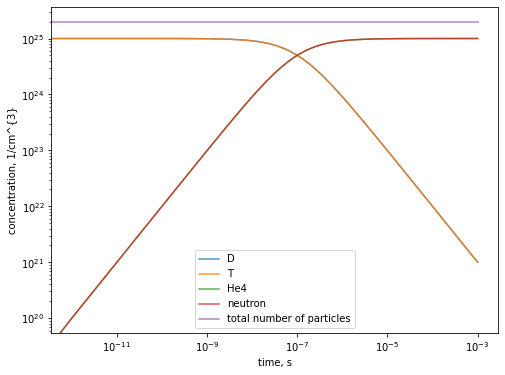

In [3]:
# select a much finer time mesh
t_lo, t_hi, t_num = 1.e-12, 1.e-3, 100
ts = numpy.exp(numpy.linspace(numpy.log(t_lo),numpy.log(t_hi),t_num))

# once again, do integration but store results (need to restart ODE solver)
advance.set_initial_value( ns_init, t_init, )
advance.set_f_params(sv)
def _helper_advance(ti,advance):
    if ti != advance.t:
        advance.integrate(ti)
    return list( itertools.chain( [ advance.t, ], advance.y, ), )
state = numpy.array( [ _helper_advance(ti,advance) for ti in itertools.chain( [ t_init, ], ts, ) ], )

# validate results
# n_D + n_T + n_He4 + n_neutron = Constant
ntot = numpy.sum( state[:,1:], axis=-1, )
tol = 1.e-12
assert numpy.all( numpy.abs(1. - ntot/ntot[0]) < tol ), 'Number of nucleons is not conserved !!!'

# plot results
fig = plt.figure( figsize=(8,6),)

plt.xlabel('time, s')
plt.ylabel('concentration, 1/cm^{3}')

plt.xscale('log')
plt.yscale('log')

for i in range(spc.num):
    plt.plot( state[:,0], state[:,i+1], label=names[i], alpha=.8, )

plt.plot( state[:,0], numpy.sum(state[:,1:], axis=-1, ), label='total number of particles', alpha=.8, )

plt.legend()
plt.show()

<h2>3. Extend the number of reactions</h2>

<p>Let's add more reactions like the D(d,p)T reaction and the D(d,n)He3 reaction. This is the extinction process of de DD reaction and it has two branches. We must consider the branching ratio in the rate equations. Also, we have two new species in the plasma and then we need to extend our state to keep track of their concentrations. Moreover, the He3 can react again with the D and the T in two new fusion reactions.</p>

<p>As a fisrt approximation, we will not take account of the reactions of He3 to keep things more simpler for this example, but after this exercise it would be straighforward to include them.</p>

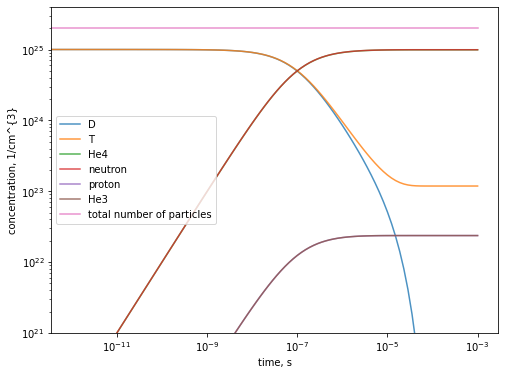

In [4]:
# define indices for each specie
spc = argparse.Namespace(
    num = 6,
    
    D = 0,
    T = 1,
    He4 = 2,
    neutron = 3,
    proton = 4,
    He3 = 5
)

# define numbers
names = { 
    spc.D: 'D', 
    spc.T: 'T', 
    spc.He4: 'He4', 
    spc.neutron: 'neutron', 
    spc.proton: 'proton',
    spc.He3: 'He3',
}

# define rate function
def func_rates(t,ns,params):
    '''
    Compute rates 
    
    -> in
    t: time, float
    ns: concentrations, array of floats
    params: extra parameters, namespace
    
    <- out
    (1) rates, array of floats (same dimension as ns)
    '''
    
    fs = numpy.zeros_like(ns)
    
    rDT = params.svDT*ns[spc.D]*ns[spc.T]
    rDD = params.svDD*ns[spc.D]*ns[spc.D]/2.
    rDD1, rDD2 = params.br1*rDD, params.br2*rDD
    
    fs[spc.D]       = - rDT - 2.*rDD
    fs[spc.T]       = - rDT + rDD1
    fs[spc.He4]     = rDT
    fs[spc.neutron] = rDT + rDD2
    fs[spc.proton]  = rDD1
    fs[spc.He3]     = rDD2
    
    return fs

# define system parameters
n0 = 1.e+25 # particles/cm3 
params = argparse.Namespace(
    kt = 15.0, # temperature, keV
    svDT = 1.e-18, # cross section for DT reaction, in cm2
    svDD = 1.e-20, # cross section for DD reaction, in cm2
    br1 = .5, # branching ratio for D(d,p)T
    br2 = .5, # branching ratio for D(d,n)He3
)

assert numpy.abs(1. - (params.br1 + params.br2)) < 1.e-9, 'Wrong definition of branching ratios'

# define initial conditions
t_init = 0.
ns_init = numpy.zeros( spc.num, )
ns_init[spc.D]       = n0
ns_init[spc.T]       = n0
ns_init[spc.He4]     = 0.
ns_init[spc.neutron] = 0.
ns_init[spc.proton]  = 0.
ns_init[spc.He3]     = 0.

# create ODE integrator
advance = scipy.integrate.ode( lambda t, ns: func_rates(t,ns,params), )
advance.set_initial_value( ns_init, t_init, )

# select timestamps
t_lo, t_hi, t_num = 1.e-12, 1.e-3, 100
ts = numpy.exp(numpy.linspace(numpy.log(t_lo),numpy.log(t_hi),t_num))

# do integration and store results
def _helper_advance(ti,advance):
    if ti != advance.t:
        advance.integrate(ti)
    return list( itertools.chain( [ advance.t, ], advance.y, ), )
state = numpy.array( [ _helper_advance(ti,advance) for ti in itertools.chain( [ t_init, ], ts, ) ], )

# validate results
ntot = numpy.sum( state[:,1:], axis=-1, )
tol = 1.e-12
assert numpy.all( numpy.abs(1. - ntot/ntot[0]) < tol ), 'Number of nucleons is not conserved !!!'

# plot results
fig = plt.figure( figsize=(8,6),)

plt.xlabel('time, s')
plt.ylabel('concentration, 1/cm^{3}')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1.e+21,4.e+25)

for i in range(spc.num):
    plt.plot( state[:,0], state[:,i+1], label=names[i], alpha=.8, )

plt.plot( state[:,0], ntot, label='total number of particles', alpha=.8, )

plt.legend()
plt.show()

<h2>4. Include energy source</h2>

<p>Some of the properties of the system can evolve with the change of species in the system. The first estep is to include the energy released by fusion reactions that is deposited locally (in the system). As other exercises tell us (exercise 4), the range of the charged particles produced in the fusion reactions is really short and they cannot scape the system. Then, the kinetic energy of the products will be scattered in the plasma locally. We are going to include the source of energy due to energy deposition of charged particles.</p>

\begin{align}
  \frac{d E}{d t} = Q_{DT}^{dep} \cdot R_{DT}^{fus} + Q_{DD}^{dep} \cdot R_{DD}^{fus}
\end{align}

<p>where $Q_{DT}^{dep}$ and $Q_{DD}^{dep}$ is the energy deposited in the plasma due to DT and DD reactions respectively. This way we track the internal energy of the system taht is the key to get the evolution of the temperature to study other effects as in the next section. Furthermore, we can include losses on energy like the Bremsthalung emission.</p>

\begin{align}
  \frac{d E}{d t} & = Q_{DT}^{dep} \cdot R_{DT}^{fus} + Q_{DD}^{dep} \cdot R_{DD}^{fus} - P_{brem} \\
  P_{brem} & = 5.35e-31 \cdot n_{e} \sum_{species} n_{i} \cdot Z_{i}^{2} T_{e}^{1/2}
\end{align}

\begin{align}
  c_{V} = \frac{R}{\gamma - 1} \\
  \gamma = \frac{5}{3}
\end{align}

/usr/lib64/python3.10/site-packages/scipy/integrate/_ode.py:1013: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


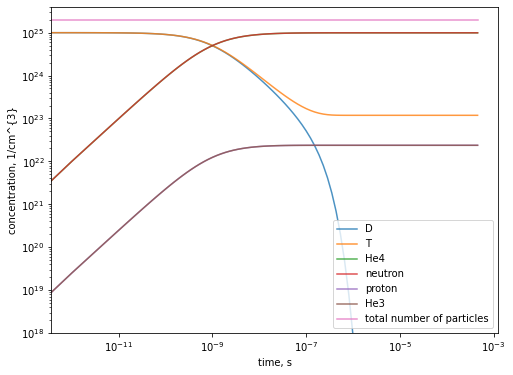

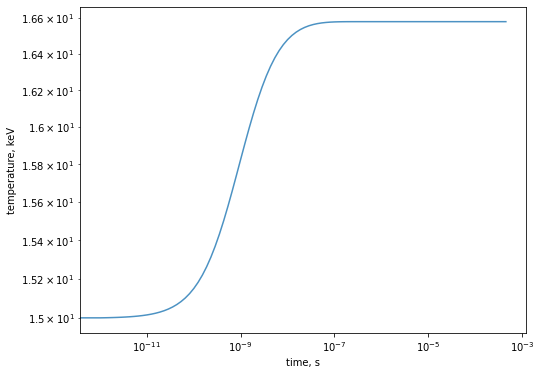

In [19]:
# define indices for each specie
spc = argparse.Namespace(
    
    num_species = 6,
    num_variables = 7,
    
    D = 0,
    T = 1,
    He4 = 2,
    neutron = 3,
    proton = 4,
    He3 = 5,
    
    energy = 6,
)

# define numbers
names = { 
    spc.D: 'D', 
    spc.T: 'T', 
    spc.He4: 'He4', 
    spc.neutron: 'neutron', 
    spc.proton: 'proton',
    spc.He3: 'He3',
    spc.energy: 'energy',
}

# define rate function
def func_rates(t,ns,params):
    '''
    Compute rates 
    
    -> in
    t: time, float
    ns: concentrations, array of floats
    params: extra parameters, namespace
    
    <- out
    (1) rates, array of floats (same dimension as ns)
    '''
    
    fs = numpy.zeros_like(ns)
    
    rDT = params.svDT*ns[spc.D]*ns[spc.T]
    rDD = params.svDD*ns[spc.D]*ns[spc.D]/2.
    rDD1, rDD2 = params.br1*rDD, params.br2*rDD
    
    ne = numpy.sum( ns*params.zs, )
    qbrem = 5.35e-31*numpy.sqrt(params.kt)*ne*numpy.sum( ns*params.zs*params.zs, )
    
    fs[spc.D]       = - rDT - 2.*rDD
    fs[spc.T]       = - rDT + rDD1
    fs[spc.He4]     = rDT
    fs[spc.neutron] = rDT + rDD2
    fs[spc.proton]  = rDD1
    fs[spc.He3]     = rDD2
    fs[spc.energy]  = params.qDT*rDT + params.qDD*rDD #- qbrem
    
    return fs

# define system parameters
n0 = 1.e+25 # 1/cm3
params = argparse.Namespace(
    n0   = n0, # initial particle density, 1/cm3
    kt   = 15.0e-3, # temperature, MeV
    svDT = 1.e-16, # cross section for DT reaction, in cm2
    svDD = 1.e-18, # cross section for DD reaction, in cm2
    br1  = .5, # branching ratio for D(d,p)T
    br2  = .5, # branching ratio for D(d,n)He3
    qDT  = 3.5, # deposited energy due to DT reactions, in MeV
    qDD  = 2.43, # deposited energy due to DD reactions, in MeV
    cv   = (3./2.)*n0, # plasma specific heat
    zs   = numpy.zeros( ( spc.num_variables, ), ), # charge of each specie
)

params.zs[spc.D] = 1.
params.zs[spc.T] = 1.
params.zs[spc.He4] = 2.
params.zs[spc.neutron] = 0.
params.zs[spc.He3] = 2.
params.zs[spc.energy] = 0.

assert numpy.abs(1. - (params.br1 + params.br2)) < 1.e-9, 'Wrong definition of branching ratios'

# define initial conditions
t_init = 0.
ns_init = numpy.zeros( spc.num_variables, )
ns_init[spc.D]       = params.n0
ns_init[spc.T]       = params.n0
ns_init[spc.He4]     = 0.
ns_init[spc.neutron] = 0.
ns_init[spc.proton]  = 0.
ns_init[spc.He3]     = 0.
ns_init[spc.energy]  = params.cv*params.kt

# create ODE integrator
advance = scipy.integrate.ode( func_rates, )
advance.set_initial_value( ns_init, t_init, )
advance.set_f_params( params )

# select timestamps
t_lo, t_hi, t_num = 1.e-12, 1.e-3, 100
ts = numpy.exp(numpy.linspace(numpy.log(t_lo),numpy.log(t_hi),t_num))

# do integration and store results
def _helper_advance(ti,advance):
    if ti != advance.t:
        advance.integrate(ti)
    return list( itertools.chain( [ advance.t, ], advance.y, ), )
state = numpy.array( [ _helper_advance(ti,advance) for ti in itertools.chain( [ t_init, ], ts, ) ], )

# split state
time, species, energy = state[:,0], state[:,1:1+spc.num_species], state[:,spc.energy]

# validate results
ntot = numpy.sum( species, axis=-1, )
tol = 1.e-12
assert numpy.all( numpy.abs(1. - ntot/ntot[0]) < tol ), 'Number of nucleons is not conserved !!!'

# plot results
fig = plt.figure( figsize=(8,6),)

plt.xlabel('time, s')
plt.ylabel('concentration, 1/cm^{3}')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1.e+18,4.e+25)

for i in range(spc.num_species):
    plt.plot( time, species[:,i], label=names[i], alpha=.8, )

plt.plot( time, ntot, label='total number of particles', alpha=.8, )

plt.legend()
plt.show()

fig = plt.figure( figsize=(8,6),)

plt.xlabel('time, s')
plt.ylabel('temperature, keV')

plt.xscale('log')
plt.yscale('log')

plt.plot( state[:,0], 1.e3*(params.kt + state[:,spc.energy]/params.cv), alpha=.8, )

plt.show()

<h2>5. Include the feedback effect of the temperature in cross sections</h2>

<p>The energy deposited will change the temperature of the system and then it will have an effect on the cross sections. We can take care of this effect through the rate function.</p>

In [ ]:
# define indices for each specie
spc = argparse.Namespace(
    
    num_species = 6,
    num_variables = 7,
    
    D = 0,
    T = 1,
    He4 = 2,
    neutron = 3,
    proton = 4,
    He3 = 5,
    
    energy = 6,
)

# define numbers
names = { 
    spc.D: 'D', 
    spc.T: 'T', 
    spc.He4: 'He4', 
    spc.neutron: 'neutron', 
    spc.proton: 'proton',
    spc.He3: 'He3',
    spc.energy: 'energy',
}

# define rate function
def func_rates(t,ns,params):
    '''
    Compute rates 
    
    -> in
    t: time, float
    ns: concentrations, array of floats
    params: extra parameters, namespace
    
    <- out
    (1) rates, array of floats (same dimension as ns)
    '''
    
    fs = numpy.zeros_like(ns)
    
    # compute temperature from internal energy, in MeV
    kt = params.kt_init + ns[spc.energy]/params.cv
    
    rDT = params.svDT(kt)*ns[spc.D]*ns[spc.T]
    rDD = params.svDD(kt)*ns[spc.D]*ns[spc.D]/2.
    rDD1, rDD2 = params.br1*rDD, params.br2*rDD
    
    qbrem = 0.
    
    fs[spc.D]       = - rDT - 2.*rDD
    fs[spc.T]       = - rDT + rDD1
    fs[spc.He4]     = rDT
    fs[spc.neutron] = rDT + rDD2
    fs[spc.proton]  = rDD1
    fs[spc.He3]     = rDD2
    fs[spc.energy]  = params.qDT*rDT + params.qDD*rDD - qbrem
    
    return fs

# define system parameters
n0 = 1.e+25 # particles/cm3
params = argparse.Namespace(
    n0   = n0, # initial particle density, 1/cm3
    kt_init  = 0.015, # initial temperature, in MeV
    svDT = lambda kt: 1.e-18 + 1.e-17*numpy.sqrt(100.*kt), # cross section for DT reaction, in cm2
    svDD = lambda kt: 1.e-20 + 1.e-19*numpy.sqrt(100.*kt), # cross section for DD reaction, in cm2
    br1  = .5, # branching ratio for D(d,p)T
    br2  = .5, # branching ratio for D(d,n)He3
    qDT  = 3.5, # deposited energy due to DT reactions, in MeV
    qDD  = 2.43, # deposited energy due to DD reactions, in MeV
    cv   = 0.1*(3./2.)*n0, # plasma specific heat
)

assert numpy.abs(1. - (params.br1 + params.br2)) < 1.e-9, 'Wrong definition of branching ratios'

# define initial conditions
t_init = 0.
ns_init = numpy.zeros( spc.num_variables, )
ns_init[spc.D]       = params.n0
ns_init[spc.T]       = params.n0
ns_init[spc.He4]     = 0.
ns_init[spc.neutron] = 0.
ns_init[spc.proton]  = 0.
ns_init[spc.He3]     = 0.
ns_init[spc.energy]  = 0.

# create ODE integrator
advance = scipy.integrate.ode( func_rates, )
advance.set_initial_value( ns_init, t_init, )
advance.set_f_params( params )

# select timestamps
t_lo, t_hi, t_num = 1.e-12, 1.e-3, 100
ts = numpy.exp(numpy.linspace(numpy.log(t_lo),numpy.log(t_hi),t_num))

# do integration and store results
def _helper_advance(ti,advance):
    if ti != advance.t:
        advance.integrate(ti)
    return list( itertools.chain( [ advance.t, ], advance.y, ), )
state = numpy.array( [ _helper_advance(ti,advance) for ti in itertools.chain( [ t_init, ], ts, ) ], )

# split state
time, species, energy = state[:,0], state[:,1:1+spc.num_species], state[:,spc.energy]

# validate results
ntot = numpy.sum( species, axis=-1, )
tol = 1.e-12
assert numpy.all( numpy.abs(1. - ntot/ntot[0]) < tol ), 'Number of nucleons is not conserved !!!'

# plot results
fig = plt.figure( figsize=(8,6),)

plt.xlabel('time, s')
plt.ylabel('concentration, 1/cm^{3}')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1.e+15,4.e+25)

for i in range(spc.num_species):
    plt.plot( time, species[:,i], label=names[i], alpha=.8, )

plt.plot( time, ntot, label='total number of particles', alpha=.8, )

plt.legend()
plt.show()

fig = plt.figure( figsize=(8,6),)

plt.xlabel('time, s')
plt.ylabel('temperature, keV')

plt.xscale('log')
plt.yscale('linear')

plt.plot( state[:,0], (params.kt_init + state[:,spc.energy]/params.cv)*units.energy.MeV_to_keV, alpha=.8, )

plt.show()

<h2>6. Improve models</h2>

<ul>
    <li>Include energy losses</li>
    <li>Include the complete set of reactions</li>
    <li>Reaction-advection? Reaction-diffusion? Reaction-advection-diffusion? Reaction-advection-transport?</li>
    <li>Energy deposited by neutrons</li>
</ul>